**Importing Libraries**

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from sklearn.metrics import f1_score
import numpy as np
from sklearn.metrics import *
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


**Reading Data**

In [3]:
data=pd.read_csv("drive/MyDrive/DataScience_Datasets/Arjun/final_feature_reviews.csv")
data=data.drop(['text','clean_text'],axis=1)
print(data.shape)
data.head(1)

(29999, 12)


,review_id,review_stars,total_len,stop_len,special_len,lemma_len,polarity,subjectivity,word_count,word_density,unique_words,mean_word_len
0,UmFMZ8PyXZTY2QcwzsfQYA,1.0,276,123,276,10,-0.026084,0.33167,276,0.99639,176,3.916667


**Train-Test Split and SMOTE Balancing**

In [4]:
data=data.fillna(0)
X=data.drop(['review_id','review_stars'], axis=1)
y=data[['review_stars']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training reviews count by each rating")
print(y_train.review_stars.value_counts())

sm = SMOTE(random_state = 2)
X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
X_train_oversampled = pd.DataFrame(X_train_oversampled, columns=X_train.columns)
y_train_oversampled=pd.DataFrame(y_train_oversampled, columns=y_train.columns)
print(y_train_oversampled.review_stars.value_counts())

balanced_train=X_train_oversampled.copy()
balanced_train['review_stars']=y_train_oversampled['review_stars']

print("Balanced Training reviews count by each rating")
print(y_train_oversampled.review_stars.value_counts())

balanced_train['review_stars']=balanced_train['review_stars'].apply(lambda x : int(x-1))

X=balanced_train.drop('review_stars',axis=1)
y=balanced_train[['review_stars']]
X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.2, random_state=42)

Training reviews count by each rating
5.0    10514
4.0     5488
1.0     3347
3.0     2699
2.0     1951
Name: review_stars, dtype: int64
3.0    10514
5.0    10514
4.0    10514
2.0    10514
1.0    10514
Name: review_stars, dtype: int64
Balanced Training reviews count by each rating
3.0    10514
5.0    10514
4.0    10514
2.0    10514
1.0    10514
Name: review_stars, dtype: int64


**LGBM Model Training**

In [5]:
lgb_train=lgb.Dataset(X_train,label=list(y_train.review_stars))
lgb_val=lgb.Dataset(X_val,label=list(y_val.review_stars))
params={'application':'multiclass',
        'num_class':5,
        'learning_rate':0.01,
        }
model=lgb.train(params,num_boost_round=10000,verbose_eval=1000,train_set=lgb_train, valid_sets=[lgb_train, lgb_val])


[1000]	training's multi_logloss: 1.00764	valid_1's multi_logloss: 1.10538
[2000]	training's multi_logloss: 0.882941	valid_1's multi_logloss: 1.04313
[3000]	training's multi_logloss: 0.790366	valid_1's multi_logloss: 1.00102
[4000]	training's multi_logloss: 0.714836	valid_1's multi_logloss: 0.969006
[5000]	training's multi_logloss: 0.649414	valid_1's multi_logloss: 0.941761
[6000]	training's multi_logloss: 0.593979	valid_1's multi_logloss: 0.919931
[7000]	training's multi_logloss: 0.545736	valid_1's multi_logloss: 0.902054
[8000]	training's multi_logloss: 0.503325	valid_1's multi_logloss: 0.886064
[9000]	training's multi_logloss: 0.463653	valid_1's multi_logloss: 0.871808
[10000]	training's multi_logloss: 0.430089	valid_1's multi_logloss: 0.860298


**Prediction on Test set**

In [6]:
preds=model.predict(X_test[X_train.columns])
y_pred = []

for x in preds:
    y_pred.append(np.argmax(x))

result=pd.DataFrame()
result['actual']=list(y_test['review_stars'])
result['prediction']=y_pred
result['prediction']=result['prediction']+1


**Crosstab on Actual vs Prediction rating**

In [7]:
pd.crosstab(result.actual, result.prediction)

prediction,1,2,3,4,5
actual,,,,,
1.0,529,129,47,43,100
2.0,154,83,83,50,100
3.0,114,73,107,115,237
4.0,74,90,148,261,799
5.0,85,77,153,392,1957


**Model Evaluation Metrics**

In [8]:
print("Accuracy is ",accuracy_score(result.actual, result.prediction))
print("Precision is ",precision_score(result.actual, result.prediction, average='weighted'))
print("Recall is ",recall_score(result.actual, result.prediction, average='weighted'))
print("F1-Score is ",f1_score(result.actual, result.prediction, average='weighted'))

Accuracy is  0.4895
Precision is  0.45544999832241423
Recall is  0.4895
F1-Score is  0.46661389199494996


**Model feature Importance**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

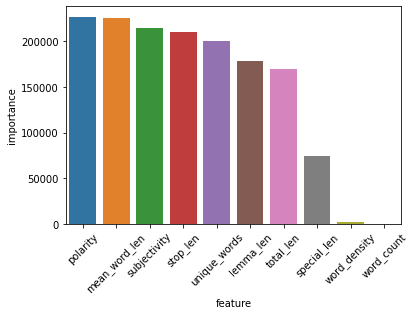

In [18]:
df_feature_importance = (
    pd.DataFrame({
        'feature': model.feature_name(),
        'importance': model.feature_importance(),
    })
    .sort_values('importance', ascending=False)
)
feature_imp_graph=sns.barplot(x='feature',y='importance',data=df_feature_importance,)
plt.xticks(rotation=45)


In [19]:
df_feature_importance

,feature,importance
4,polarity,226790
9,mean_word_len,225445
5,subjectivity,214611
1,stop_len,210361
8,unique_words,200242
3,lemma_len,177902
0,total_len,169043
2,special_len,73787
7,word_density,1819
6,word_count,0


**Model Performance Improvements**

1. Use different models and perform an ensembled approach
2. Tried undersampling all the classes to match with minority class, but performance is not as good as oversampling
3. Can use more data on a single category like restaurant to improve model performance as every category has a different pattern of review
4. Perform Hyperparameter optimization